### load and explore 

In [8]:
data_path = './data/Training_data.txt'
vocab_path = './data/vocab.txt'

In [9]:
import pandas as pd
df = pd.read_csv(data_path,sep='\t')

### Stratified Split (train,val,test: 0.6, 0.2, 0.2) 

In [40]:
# split
from matplotlib import pyplot as plt
df.columns = ['seq','label']

from sklearn.model_selection import train_test_split as tts
a = tts(df,test_size=0.2,shuffle=True,stratify=df['label'],random_state=1004)

tr,val = tts(a[0],test_size=0.25,shuffle=True,stratify=a[0]['label'],random_state=1004)
te = a[1]

In [83]:
len(tr),len(val),len(te)

(21834, 7278, 7279)

In [89]:
tr.to_csv('./data/split/train.csv',index_label='index')
val.to_csv('./data/split/val.csv',index_label='index')
te.to_csv('./data/split/test.csv',index_label='index')

### Dataset & DataLoader for pytorch 

In [14]:
transform = 'onehot'
batch_size = 16 # 64
def get_vocab_map(vocab_path='./data/vocab.txt'):
    with open(vocab_path,'r') as f:
        vocab = f.read()

    vocab = vocab.replace('\n','')

    import re
    p = re.compile('\s+')
    vocab = re.sub(p,' ',vocab)

    import ast
    vocab = ast.literal_eval(vocab.split('=')[1].strip())

    len_vocab = len(vocab)
    vocab_map = dict(zip(vocab,range(len_vocab)))
    return vocab_map
vocab_map =get_vocab_map()

import torch
from torch.nn import functional as F
import pandas as pd
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self,path,transform='oneHot',onlyOne=False):
        self.df        = pd.read_csv(path)
        if type(transform) == str:
            self.transform = transform.lower()
        else:
            self.transform = transform
        
        if onlyOne:
            self.df = self.df[self.df.label == 1]
            
    def __getitem__(self,idx):
        item = self.df.iloc[idx]
        x = item['seq']
        y = item['label']
        
        if self.transform == 'onehot':
            x = self.seq2oneHot(x)
        elif self.transform is None:
            x = self.seq2int(x)
        elif self.transform == 'ae':
            x = self.seq2oneHot(x)
            y = x 
            return x,y
            
        y = torch.tensor(y)
        # y = self.label2oneHot(y)
        return x,y
    
    def __len__(self):
        return len(self.df)
    
    def seq2int(self,seq):
        seq2int = [ vocab_map[x] for x in list(seq) ]
        seq2int = torch.tensor(seq2int)
        return seq2int
    
    def seq2oneHot(self,seq): # 'ABCDE..' -> OneHot (10,20) 
        seq2int = self.seq2int(seq)
        oneHot = F.one_hot(seq2int,num_classes=len(vocab_map) )
        return oneHot
    
    def label2oneHot(self,label):
        return F.one_hot(torch.tensor(label),num_classes=2)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trdt  = ProteinDataset('./data/split/train.csv',transform=transform)
valdt = ProteinDataset('./data/split/val.csv'  ,transform=transform)
tedt  = ProteinDataset('./data/split/test.csv' ,transform=transform)

trdl  = torch.utils.data.DataLoader(trdt, batch_size=batch_size, num_workers=4)
valdl  = torch.utils.data.DataLoader(valdt, batch_size=batch_size, num_workers=4)
tedl  = torch.utils.data.DataLoader(tedt, batch_size=batch_size, num_workers=4)

### Model 

|i|model | used|
|---|--------| ----|
|0  |ResNet| ✔|
|1  | ResNext   |x|
|2  | MaxFilterCNN|✔ |
|3  | LSTM|     x|
|4  |Self-attention|✔ |
<!-- |5  ||✔ | -->


#### ResNet 

In [2]:
import torchvision

### x: b,10,20
from torch import nn
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        in_nodes = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_nodes,2)
    def forward(self,x):
        x = x.to(torch.float)
        x = torch.stack([x,x,x],dim=1)
        x = self.backbone(x)
        return x
        

#### ResNext 

In [2]:
import torchvision

### x: b,10,20
from torch import nn
class ResNext(nn.Module):
    def __init__(self):
        super(ResNext,self).__init__()
        self.backbone = torchvision.models.resnext50_32x4d(pretrained=True)
        in_nodes = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_nodes,2)
    def forward(self,x):
        x = x.to(torch.float)
        x = torch.stack([x,x,x],dim=1)
        x = self.backbone(x)
        return x
        

#### MaxFilterCNN 

In [2]:
### x: b,10,20
from torch import nn
class MaxFilterCNN(nn.Module):
    def __init__(self):
        super(MaxFilterCNN,self).__init__()
        self.maxFconv = nn.Sequential(
            nn.Conv2d(1,8,kernel_size=(3,20) ),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        class squeeze(nn.Module):
            def __init__(self):
                super(squeeze,self).__init__()
            def forward(self,x):
                x = x.squeeze(-1)
                return x
        self.sq = squeeze()
        self.conv1d0 = nn.Sequential(
                    nn.Conv1d(8,8,kernel_size=3),
                    # nn.MaxPool1d(2),
                    nn.BatchNorm1d(8),
                    nn.ReLU()
                )
        self.conv1d1 = nn.Sequential(
                    nn.Conv1d(8,8,kernel_size=2),
                    # nn.MaxPool1d(2),
                    nn.BatchNorm1d(8),
                    nn.ReLU()
                )

        mli = nn.ModuleList([self.maxFconv,self.sq,self.conv1d0,self.conv1d1])
        sample = torch.rand(1,1,10,20)
        for f in mli:
            sample = f(sample)
        b,c,l = sample.shape
        num_node  = c*l 

        self.last = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(num_node,2)
                )
    def forward(self,x):
        x = x.to(torch.float)
        x = x.unsqueeze(1)
        x = self.maxFconv(x)
        x = self.sq(x)
        x = self.conv1d0(x)
        x = self.conv1d1(x)
        x = self.last(x)
        return x
        

####  LSTM

##### lstm (w/ OH) 

In [2]:
# lstm: /w oneHot encoding
import torchvision

### x: b,10,20
from torch import nn
class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.lstm0 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.fc = nn.Linear(20,2)
        
    def forward(self,x):
        x        = x.to(torch.float)
        x,(h,c)  = self.lstm0(x)
        al,(x,c) = self.lstm1(x)
        x        = x.transpose(0,1)
        x        = x.squeeze()
        x        = self.fc(x)
        return x
        

##### lstm0 (w/o OH) 

In [62]:
# lstm0: /wo oneHot encoding
import torchvision

### x: b,10,20
from torch import nn
class lstm0(nn.Module):
    def __init__(self):
        super(lstm0,self).__init__()
        self.lstm0 = nn.LSTM(input_size = 1, hidden_size = 10,num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size = 10, hidden_size = 10,num_layers=1, batch_first=True)
        self.fc = nn.Linear(10,2)
        
    def forward(self,x):
        x        = x.to(torch.float)
        
        x        = x.unsqueeze(-1)
        x,(h,c)  = self.lstm0(x)
        al,(x,c) = self.lstm1(x)
        x        = x.transpose(0,1)
        x        = x.squeeze()
        x        = self.fc(x)
        return x
        

##### lstm1 (w/ embedding) 

In [126]:
# lstm: /w oneHot encoding
import torchvision

### x: b,10,20
from torch import nn
class lstm1(nn.Module):
    def __init__(self):
        super(lstm1,self).__init__()
        self.emb   = nn.Embedding(20,20)
        self.lstm0 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.fc = nn.Linear(20,2)
        
    def forward(self,x):
        x        = self.emb(x)
        x,(h,c)  = self.lstm0(x)
        al,(x,c) = self.lstm1(x)
        x        = x.transpose(0,1)
        x        = x.squeeze()
        x        = self.fc(x)
        return x
        

##### lstm2 (w/ emb + positional embedding) 

In [ ]:
from models import PostionalEncoding
pe = PostionalEncoding(10,20)

In [3]:
# lstm: /w oneHot encoding
import torchvision
from models import PostionalEncoding
### x: b,10,20
from torch import nn
class lstm2(nn.Module):
    def __init__(self):
        super(lstm2,self).__init__()
        self.emb   = nn.Embedding(20,20)
        self.pe    = PostionalEncoding(max_len=10,d_model=20,device=device)
        self.lstm0 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size = 20, hidden_size = 20,num_layers=1, batch_first=True)
        self.fc = nn.Linear(20,2)
        
    def forward(self,x):
        x        = self.emb(x)+self.pe(x)
        x,(h,c)  = self.lstm0(x)
        al,(x,c) = self.lstm1(x)
        x        = x.transpose(0,1)
        x        = x.squeeze()
        x        = self.fc(x)
        return x
        

####  Self-attention

##### attn (w/) 

In [76]:
import torchvision

### x: b,10,20
from torch import nn
class attns(nn.Module):
    def __init__(self):
        super(attns,self).__init__()
        self.attn0 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.attn1 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.flat  = nn.Flatten()
        self.fc    = nn.Sequential(
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,2)
        )
        
    def forward(self,x):
        x = x.to(torch.float)
        x = self.attn0(x)+x
        x = self.attn1(x)+x
        x = self.flat(x)
        x = self.fc(x)
        return x
        

##### attn0 (w/o OH) 

In [66]:
import torchvision

### x: b,10,20
from torch import nn
class attns0(nn.Module):
    def __init__(self):
        super(attns0,self).__init__()
        self.attn0 = nn.TransformerEncoderLayer(d_model=1, nhead=1,batch_first=True)
        self.attn1 = nn.TransformerEncoderLayer(d_model=1, nhead=1,batch_first=True)
        self.flat  = nn.Flatten()
        self.fc    = nn.Sequential(
            nn.Linear(10,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )
        
    def forward(self,x):
        x = x.to(torch.float) # b,10
        x = x.unsqueeze(-1)   # b,10,1
        x = self.attn0(x)+x   # b,10,1
        x = self.attn1(x)+x   # b,10,1
        x = self.flat(x)      # b,10
        x = self.fc(x)        # b,2
        return x
        

##### attns1 (w/ embedding  w/o oneHot ) 

In [117]:
import torchvision

### x: b,10,20
from torch import nn
class attns1(nn.Module):
    def __init__(self):
        super(attns1,self).__init__()
        self.emb   = nn.Embedding(20,20)
        self.attn0 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.attn1 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.flat  = nn.Flatten()
        self.fc    = nn.Sequential(
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,2)
        )
        
    def forward(self,x):

        x = self.emb(x)       # b,10,20
        x = self.attn0(x)+x   # b,10,20
        x = self.attn1(x)+x   # b,10,20
        x = self.flat(x)      # b,200
        x = self.fc(x)        # b,2
        return x
        

##### attns2 (w/ emb + positional emb) 

In [19]:
import torchvision
from models import PostionalEncoding
### x: b,10,20
from torch import nn
class attns2(nn.Module):
    def __init__(self):
        super(attns2,self).__init__()
        self.emb   = nn.Embedding(20,20)
        self.pe    = PostionalEncoding(max_len=10,d_model=20,device=device)
        self.drop_out = nn.Dropout(p=0.3)
        self.attn0 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.attn1 = nn.TransformerEncoderLayer(d_model=20, nhead=4,batch_first=True)
        self.flat  = nn.Flatten()
        self.fc    = nn.Sequential(
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,2)
        )
        
    def forward(self,x):
        
        x = self.emb(x)+self.pe(x)       # b,10,20
        # x = self.drop_out(x)
        x = self.attn0(x)+x   # b,10,20
        x = self.attn1(x)+x   # b,10,20
        x = self.flat(x)      # b,200
        x = self.fc(x)        # b,2
        return x
        

#### Vision transformer 

##### vit0 

In [2]:
import torchvision
import timm
### x: b,10,20
from torch import nn
from torchvision import transforms

class vit0(nn.Module):
    def __init__(self):
        super(vit0,self).__init__()

        self.transform = transforms.Compose([
            transforms.Resize(size = (224,224),interpolation=transforms.InterpolationMode.BICUBIC,max_size=None, antialias=None),
            transforms.Normalize(mean=[0.5000, 0.5000, 0.5000],std=[0.5000, 0.5000, 0.5000] )
        ])
        self.backbone =  timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

    def forward(self,x):
        x = x.to(torch.float)
        x = torch.stack([x,x,x],dim=1)
        x = self.transform(x)
        x = self.backbone(x)
        return x


##### vit1 (small) 

In [6]:
from timm.models import vision_transformer as vt

### x: b,10,20
from torch import nn
class vit1(nn.Module):
    def __init__(self):
        super(vit1,self).__init__()
        self.vit = vt.VisionTransformer(img_size=(10,20),patch_size=5,num_classes=2,embed_dim=384,in_chans=1,depth=4)
        
    def forward(self,x):
        x = x.to(torch.float)
        x = x.unsqueeze(1)
        x = self.vit(x)
        return x


#### AE (AutoEncoder) 

In [2]:
from torch import nn
def get_conv(in_n,out_n,kernel_size=(3, 3), stride=(1, 1),activation=True):
    c = nn.Conv2d(in_n,out_n,kernel_size=kernel_size,stride=stride)
    b = nn.BatchNorm2d(out_n)
    if activation == True:
        r = nn.ReLU()
        return nn.Sequential(c,b,r)
    else:
        return nn.Sequential(c,b)

def get_deconv(in_n,out_n,kernel_size=(3, 3), stride=(1, 1),activation=True):
    dc = nn.ConvTranspose2d(in_n,out_n,kernel_size=kernel_size, stride=stride)
    b  = nn.BatchNorm2d(out_n)
    r  = nn.ReLU()
    combo = nn.Sequential(dc,b,r)
    return combo

class encoder0(nn.Module):
    def __init__(self):
        super(encoder0,self).__init__()
        e0 = get_conv(1,8)
        e1 = get_conv(8,16)
        e2 = get_conv(16,32,activation=False)
        e3 = nn.AdaptiveAvgPool2d((2,2))
        e4  = nn.Flatten()
        self.enc = nn.Sequential(e0,e1,e2,e3,e4)
        out_node = self.enc(torch.rand(1,1,10,20)).shape[-1]
        e5  = nn.Linear(out_node,64)
        self.enc.add_module('lin',e5)
    def forward(self,x):
        x = x.unsqueeze(1) # b,10,20 > b,1,10,20
        x = self.enc(x)
        return x 

from torch.nn import functional as F
class decoder0(nn.Module):
    def __init__(self):
        super(decoder0,self).__init__()
        d0 = get_deconv(32,16,stride=(1,1))
        d1 = get_deconv(16,8,stride=(2,2))
        d2 = get_deconv(8,8,stride=(1,2))
        self.d3 = nn.Conv2d(8,1,kernel_size=(3,3),stride=1)
        # d4 = nn.Conv2d(8,1)
        self.dec = nn.Sequential(d0,d1,d2)
    def forward(self,x):
        x = x.view(x.size()[0],32,1,2)
        x = self.dec(x)
        x = F.interpolate(x,(12,22))
        x = self.d3(x)
        x = x.squeeze()
        return x 

from torch.nn import functional as F
class AE0(nn.Module):
    def __init__(self):
        super(AE0,self).__init__()
        self.en = encoder0()
        self.de = decoder0()
    def forward(self,x):
        x = self.en(x)
        x = self.de(x)
        return x 

### settings 

In [8]:
it = iter(trdl)
x,y = next(it)

In [ ]:
from 

In [3]:
# model = 'lstm2'
# model = 'attns2'
model = 'vit0'

model = model.lower()
if model.startswith('maxfil'):
    model = MaxFilterCNN().to(device)
elif model.startswith('resnet'):
    model = ResNet().to(device)
elif model.startswith('resnext'):
    model = ResNext().to(device)
elif model.startswith('attn'):
    if model == 'attns':
        transform = 'onehot'
        model = attns().to(device)
    elif model == 'attns0':
        transform = None
        model = attns0().to(device)
    elif model == 'attns1':
        transform = None
        model = attns1().to(device)
    elif model == 'attns2':
        transform = None
        model = attns2().to(device)
elif model.startswith('lstm'):
    if model == 'lstm':
        model = lstm().to(device)
        transform = 'onehot'
    elif model == 'lstm0':
        model = lstm0().to(device)
        transform = None
    elif model == 'lstm1':
        model = lstm1().to(device)
        transform = None
    elif model == 'lstm2':
        model = lstm2().to(device)
        transform = None
        
elif model.startswith('vit'):
    if model == 'vit0':
        model = vit0().to(device)
        transform = 'onehot'
# elif model.startswith('vit'):
#     model = Vit().to(device)    
    
loss = nn.CrossEntropyLoss()
params = [p for p in model.parameters() if p.requires_grad]
opt  = torch.optim.Adam(params)

### train/val/test 

In [ ]:
### def train(dl,model,lossf,opt):
    model.train()
    for x,y in dl:
        x,y = x.to(device),y.to(device)
        pre = model(x)
        loss = lossf(pre,y)

        opt.zero_grad()
        loss.backward()
        opt.step()

def test(dl,model,lossf,epoch=None):
    model.eval()
    size, acc , losses = len(dl.dataset) ,0,0
    with torch.no_grad():
        for x,y in dl:
            x,y = x.to(device),y.to(device)
            pre = model(x)
            loss = lossf(pre,y)
    
            acc += (pre.argmax(1)==y).type(torch.float).sum().item()
            losses += loss.item()
    accuracy = round(acc/size,4)
    val_loss = round(losses/size,6)
    print(f'[{epoch}] acc/loss: {accuracy}/{val_loss}')
    return accuracy,val_loss

import copy
patience = 5
val_losses = {0:1}
for i in range(100):
    train(trdl,model,loss,opt)
    acc,val_loss = test(valdl,model,loss,i)
    
    
    if min(val_losses.values() ) > val_loss:
        val_losses[i] = val_loss
        best_model = copy.deepcopy(model)
    if i == min(val_losses,key=val_losses.get)+patience:
        break

In [5]:
test(valdl,best_model,loss)

[None] acc/loss: 0.7306/0.033371


(0.7306, 0.033371)

In [22]:
test(tedl,best_model,loss)

[None] acc/loss: 0.8478/0.005596


(0.8478, 0.005596)

### Evaluate 

In [13]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
# from sklearn.metrics import make_scorer
# from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

def evaluate(dl,model,lossf,epoch=None):
    model.eval()
    size, _ , losses = len(dl.dataset) ,0,0
    pre_l,gt_l = [],[]
    with torch.no_grad():
        for x,y in dl:
            x,y = x.to(device),y.to(device)
            pre = model(x)
            loss = lossf(pre,y)
            
            losses += loss.item()
            pre_l.extend(pre.argmax(1).cpu().numpy().tolist())
            gt_l .extend(y.cpu().numpy().tolist())
    
    loss     = losses/size
    acc      = accuracy_score(gt_l,pre_l)
    recall   = recall_score(gt_l,pre_l)
    precision= precision_score(gt_l,pre_l)
    f1       = f1_score(gt_l,pre_l)
    confusion= confusion_matrix(gt_l,pre_l)

    metrics = {'acc':acc,'recall':recall,'precision':precision,'f1':f1,'confusion':confusion,'loss':loss}
    return metrics

print(evaluate(tedl,best_model,loss))

{'acc': 0.8479186701469982, 'recall': 0.7309397163120568, 'precision': 0.7673336435551419, 'f1': 0.748694665153235, 'confusion': array([[4523,  500],
       [ 607, 1649]]), 'loss': 0.005515566614404913}


## ETC 

### Save model 

In [26]:
import os
model_name = f"{best_model.__str__().split('(')[0]}_{max(val_losses)}.pt"
model_path = os.path.join('./models',model_name) 
torch.save(best_model.state_dict(),model_path)

### load saved models and evaluate them 

In [50]:
files = os.listdir('./models')

model_paths = [os.path.join('./models',file) for file in files if file.endswith('.pt')]

import os
from models import * 
results = {}

for m_path in model_paths:
    model_name = os.path.basename(m_path).split('_')[0]
    model_name = model_name.lower()
    
    model = model_name

    model = model.lower()
    if model.startswith('maxfil') :
        model = MaxFilterCNN().to(device)
    elif model.startswith('resnet'):
        model = ResNet().to(device)
    elif model.startswith('resnext'):
        model = ResNext().to(device)
    elif model.startswith('attn'):
        model = attns().to(device)
    elif model.startswith('lstm'):
        model = lstm().to(device)
    
    
    model.load_state_dict(torch.load(m_path))
    
    loss = nn.CrossEntropyLoss()
    
    result = evaluate(tedl,model,loss)
    
    print(f'{model_name}: {result}')
    results[model_name] = result

import pandas as pd
df  = pd.DataFrame(results).T

models = [os.path.splitext( os.path.basename(path) )[0] for path in model_paths]

df.to_csv(f"assets/{'&'.join(models)}.csv")

### Inference 

In [125]:
def get_seqStr(path = './data/sample.txt'):
    with open(path,'r',encoding='utf8') as f:
        x_list = f.readlines()

    x_list = list(map(lambda x:x.replace('\n',''),x_list ) )
    return x_list

def seq2oneHot(seq):
    seq2int = [ vocab_map[x] for x in seq ]
    seq2int = torch.tensor(seq2int)
    oneHot = F.one_hot(seq2int,num_classes=len(vocab_map) )
    return oneHot

def seq_list2oneHot(seq_list):
    tensor_list = list(map(seq2oneHot,seq_list))
    seq_tensor = torch.stack(seq_tensor_list)
    return seq_tensor


In [132]:
x = seq_list2oneHot(get_seqStr()).to(device)

In [134]:
y = model(x)
y = y.argmax(1)
y = y.cpu().numpy().tolist()

### save output 

In [137]:
# save output
y = list(map(str,y))
dirname = os.path.dirname(path)
fname   = os.path.basename(path).split('.')[0]
savep   = os.path.join(dirname,f'{fname}_out.csv')
with open(savep,'w') as f:
    f.write('\n'.join(y) )

### result to md 

In [8]:
import pandas as pd
df = pd.read_csv('./assets/MaxFilterCNN_8&lstm1_21&lstm_39&lstm0_99&vit0_7&attns_3&lstm2_18&ResNext_5&ResNet_2&vit1_14&attns0_99&attns1_3&attns2_2.csv')

In [9]:
df = df.set_index('Unnamed: 0')

In [10]:
with open('df.md','w') as f:
    f.write(df.to_markdown())

## ETC of ETC 

In [1]:
from models import get_model
model,conf = get_model('ae0')

from torch import nn
import torch
loss = nn.MSELoss()
params = [p for p in model.parameters() if p.requires_grad]
opt  = torch.optim.Adam(params)

In [2]:
from dataset import ProteinDataset
transform = 'ae'
trone  = ProteinDataset('./data/split/train.csv',transform=transform,only=1)
trzero = ProteinDataset('./data/split/train.csv'  ,transform=transform,only=0)


onedl  = torch.utils.data.DataLoader(trone, batch_size=1, num_workers=4)
zerodl  = torch.utils.data.DataLoader(trzero, batch_size=1, num_workers=4)

In [3]:
model.load_state_dict(torch.load('./models/ae0_56.pt') )

<All keys matched successfully>

In [4]:
# x x 
from options.train_op import args
device= args.device
one_losses = []
zero_losses = []
torch.multiprocessing.set_sharing_strategy('file_system')
model = model.to(device)
for x,y in onedl:
    x,y = x.to(device),y.to(device)
    pre = model(x)
    one_losses.append(loss(pre,y).item())

for x,y in zerodl:
    x,y = x.to(device),y.to(device)
    pre = model(x)
    zero_losses.append(loss(pre,y).item())

/home/yp/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 10, 20])) that is different to the input size (torch.Size([10, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [5]:
import pandas as pd
one_df = pd.DataFrame(one_losses)
zero_df = pd.DataFrame(zero_losses)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

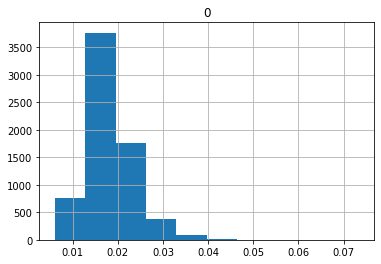

In [6]:
one_df.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

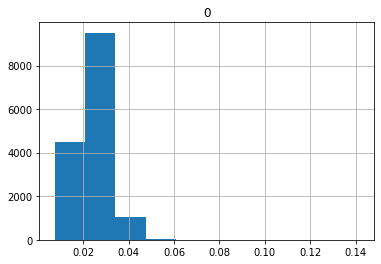

In [7]:
zero_df.hist()

In [14]:
one_df = one_df*1000
zero_df = zero_df*1000

In [15]:
one_df.describe()

,0
count,6766.000000
mean,18.178686
std,5.167735
min,5.986304
25%,14.619229
50%,17.384728
75%,20.755943
max,73.419847


In [16]:
zero_df.describe()

,0
count,15068.000000
mean,24.577854
std,6.790325
min,7.339514
25%,19.919242
50%,23.932157
75%,28.471264
max,141.441479


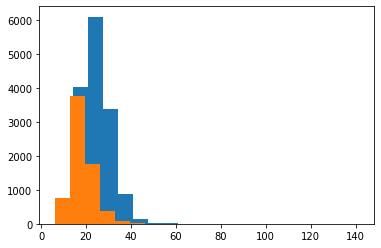

In [19]:
from matplotlib import pyplot as plt
plt.hist(zero_df,bins=20)
plt.hist(one_df)
plt.show()